In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

from sklearn.model_selection import train_test_split
# instead of LinearRegression, we'll use Ridge
# This is a numerically more stable modification of conventional linear regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# we will measure the quality of predictions using standard MSE
from sklearn.metrics import mean_squared_error
# to normalize the data, we will use MinMixScaler
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

In [2]:
def visualize_coefficients(coefs, feature_names, top_n):
    """Функция для визуализации коэффициентов линейной регрессии.

    Параметры:
        coefs: коэффициенты модели (model.coef_).
        feature_names: названия признаков (X_train.columns).
        top_n: вывести top_n самых положительных и top_n самых отрицательных признаков.
    """
    feature_names = np.array(feature_names)
    if top_n * 2 > len(coefs):
        n_pos = len(coefs) // 2
        n_neg = len(coefs) - n_pos
    else:
        n_pos, n_neg = top_n, top_n
    # нам нужно найти индексы top_n наибольших и top_n наименьших коэффициентов
    min_coef_idxs = np.argsort(coefs)[:n_neg]
    max_coef_idxs = np.argsort(coefs)[len(coefs) - n_pos:]
    # соответствующие имена фичей
    top_feature_names = np.concatenate((feature_names[min_coef_idxs], feature_names[max_coef_idxs]))
    # отобразим на bar-графике
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(np.arange(n_neg), coefs[min_coef_idxs], color=sns.xkcd_rgb["mauve"], hatch="/")
    ax.bar(np.arange(n_neg, n_neg + n_pos), coefs[max_coef_idxs], color=sns.xkcd_rgb["teal"], hatch="\\")
    ax.set_xticks(np.arange(0, n_neg + n_pos))
    ax.set_xticklabels(top_feature_names, rotation=45, ha="right", fontsize=14)
    plt.show()

In [3]:
def visualize_preds(y_true, y_pred, n_hours=336):
    """Функция для визуализации таргета и предсказаний.

    Параметры:
        y_true: правильные ответы.
        y_pred: предсказания модели.
        n_hours: вывести на график заданное число точек с конца. По умолчанию 2 недели.

    """
    fig, ax = plt.subplots(figsize=(21, 9))
    index = y_true[-n_hours:].index.sort_values()
    ax.plot(index, y_true[-n_hours:], label="y_true")
    ax.plot(index, y_pred[-n_hours:], label="y_pred")
    ax.legend()
    plt.show()

# Data loading


In [61]:
pathReal = Path.cwd() / 'vertical_capacity_shiftedhour.csv'

df = pd.read_csv(pathReal)

In [62]:
df

,timestamp,id,capacity,month,hour,day_of_week_weekend_work,season,time,rate_hour,shifted_hour,capacity_difference,capacity_difference_by2,day_of_month,day_of_year
0,2013-01-01 00:00:00,0,0.460,1.0,0.0,0.0,0.0,00:00:00,0.0,20.0,0.460,0.460,1.0,149.0
1,2013-01-01 01:00:00,0,0.426,1.0,1.0,0.0,0.0,01:00:00,0.0,21.0,-0.034,0.426,1.0,149.0
2,2013-01-01 02:00:00,0,0.411,1.0,2.0,0.0,0.0,02:00:00,0.0,22.0,-0.015,-0.049,1.0,149.0
3,2013-01-01 03:00:00,0,0.395,1.0,3.0,0.0,0.0,03:00:00,0.0,23.0,-0.016,-0.031,1.0,149.0
4,2013-01-01 04:00:00,0,0.221,1.0,4.0,0.0,0.0,04:00:00,0.0,0.0,-0.174,-0.190,1.0,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14711779,2013-06-05 19:00:00,1679,0.587,6.0,19.0,0.0,1.0,19:00:00,0.0,15.0,0.093,0.205,5.0,304.0
14711780,2013-06-05 20:00:00,1679,0.413,6.0,20.0,0.0,1.0,20:00:00,0.0,16.0,-0.174,-0.081,5.0,304.0
14711781,2013-06-05 21:00:00,1679,0.396,6.0,21.0,0.0,1.0,21:00:00,0.0,17.0,-0.017,-0.191,5.0,304.0
14711782,2013-06-05 22:00:00,1679,0.498,6.0,22.0,0.0,1.0,22:00:00,0.0,18.0,0.102,0.085,5.0,304.0


In [63]:
claster_df = pd.read_csv(Path.cwd() / 'clasters (1).csv', index_col='id')

In [78]:
full_df = pd.merge(df, claster_df, how='left', left_on='id', right_on='id').drop(['capacity_difference_by2', 'time'], axis=1).fillna(0)

In [8]:
full_df = full_df.loc[full_df['claster'] == 0]
full_df.drop(['claster'], axis=1)

,timestamp,id,capacity,month,weekday,hour,Holiday,day_of_week_weekend_work,season,time,rate_hour
8760,2013-01-01 00:00:00,1,3.888,1,1,0,0,0,0,00:00:00,0
8761,2013-01-01 01:00:00,1,2.603,1,1,1,0,0,0,01:00:00,0
8762,2013-01-01 02:00:00,1,2.159,1,1,2,0,0,0,02:00:00,0
8763,2013-01-01 03:00:00,1,2.040,1,1,3,0,0,0,03:00:00,0
8764,2013-01-01 04:00:00,1,1.495,1,1,4,0,0,0,04:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...
36126235,2013-12-31 19:00:00,4123,0.220,12,1,19,0,0,0,19:00:00,0
36126236,2013-12-31 20:00:00,4123,0.221,12,1,20,0,0,0,20:00:00,0
36126237,2013-12-31 21:00:00,4123,0.220,12,1,21,0,0,0,21:00:00,0
36126238,2013-12-31 22:00:00,4123,0.170,12,1,22,0,0,0,22:00:00,0


In [79]:
train_df, val_df = train_test_split(full_df, test_size=0.15)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 664008 entries, 13424854 to 19976151
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   timestamp                 664008 non-null  object 
 1   id                        664008 non-null  int64  
 2   capacity                  664008 non-null  float64
 3   month                     664008 non-null  int64  
 4   weekday                   664008 non-null  int64  
 5   hour                      664008 non-null  int64  
 6   Holiday                   664008 non-null  int64  
 7   day_of_week_weekend_work  664008 non-null  int64  
 8   season                    664008 non-null  int64  
 9   time                      664008 non-null  object 
 10  rate_hour                 664008 non-null  int64  
 11  claster                   664008 non-null  int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 65.9+ MB


In [80]:
train_df.head()

,timestamp,id,capacity,month,hour,day_of_week_weekend_work,season,rate_hour,shifted_hour,capacity_difference,day_of_month,day_of_year,claster
8449300,2013-07-14 04:00:00,964,0.000,7.0,4.0,1.0,2.0,0.0,0.0,0.000,14.0,343.0,0
9250921,2013-01-16 01:00:00,1056,0.076,1.0,1.0,0.0,0.0,0.0,21.0,-0.092,16.0,164.0,1
5853036,2013-02-26 12:00:00,668,1.507,2.0,12.0,0.0,0.0,1.0,8.0,-0.267,26.0,205.0,1
8139276,2013-02-21 12:00:00,929,0.332,2.0,12.0,0.0,0.0,1.0,8.0,0.177,21.0,200.0,1
139487,2013-12-03 23:00:00,15,1.017,12.0,23.0,0.0,0.0,0.0,19.0,0.017,3.0,120.0,1


# Trainee

In [73]:
def prepare_data_trainee(train_df, val_df):
    X_train = train_df.drop(['capacity', 'timestamp', 'id'], axis=1)
    X_val = val_df.drop(['capacity', 'timestamp', 'id'], axis=1)

    feature_names = X_train.columns.tolist()

    y_train = train_df["capacity"]
    y_val = val_df["capacity"]

    scl = MinMaxScaler()
    X_train = scl.fit_transform(X_train)
    X_val = scl.transform(X_val)
    return X_train, y_train, X_val, y_val, feature_names, scl

In [81]:
X_train, y_train, X_val, y_val, feature_names, scl = prepare_data_trainee(train_df, val_df)

In [82]:
# train the model
model = Lasso(1e-4)
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)

print(f"Train MSE: {train_mse}")

val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)

print(f"Validation MSE: {val_mse}")

Train MSE: 0.18991413357499998
Validation MSE: 0.19064076230191587


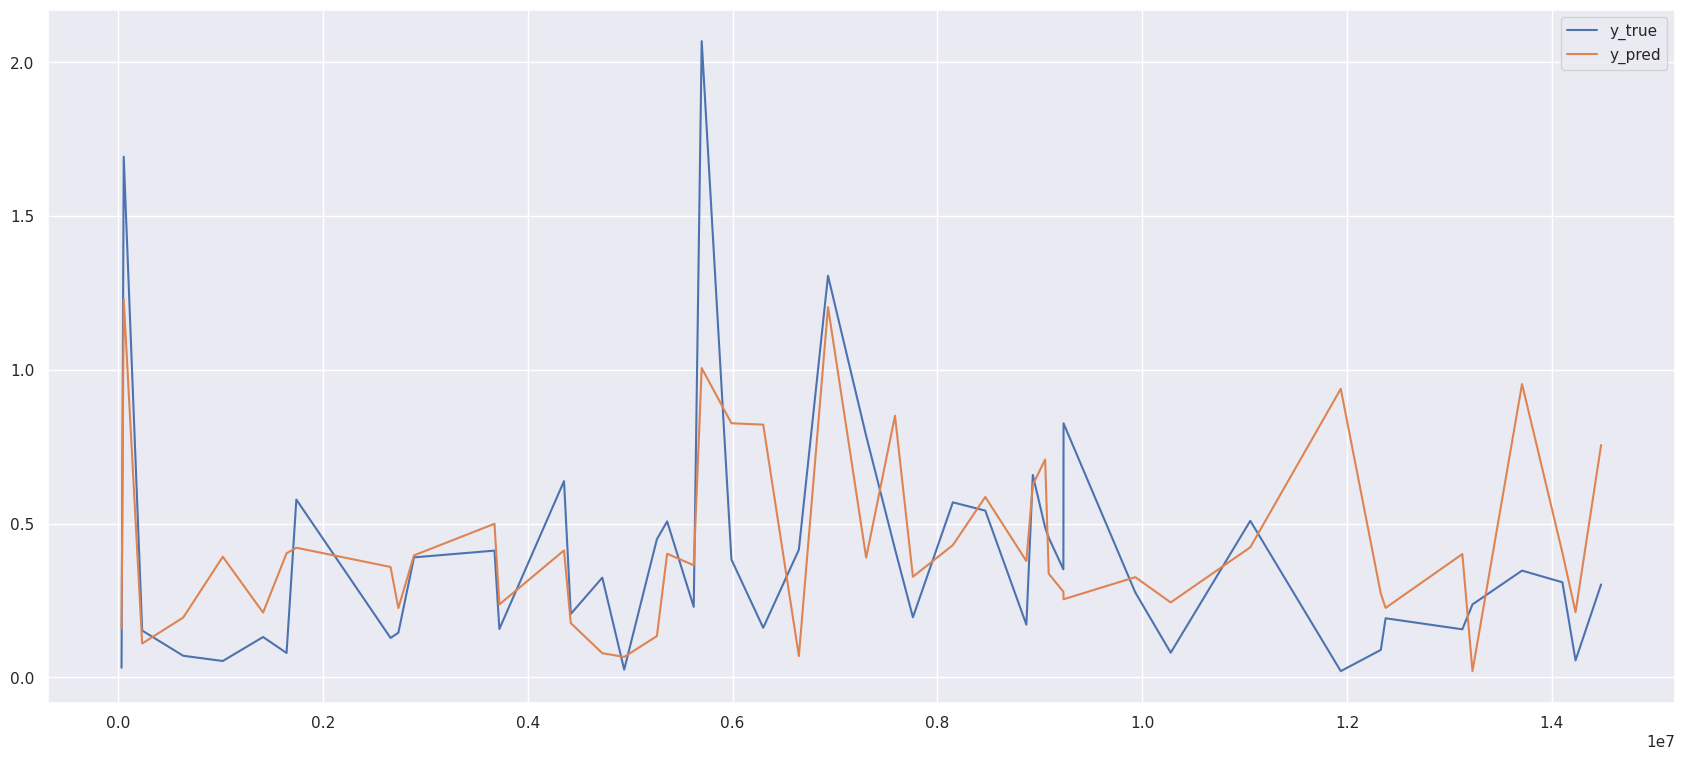

In [83]:
visualize_preds(y_val, val_predictions, 24*2)

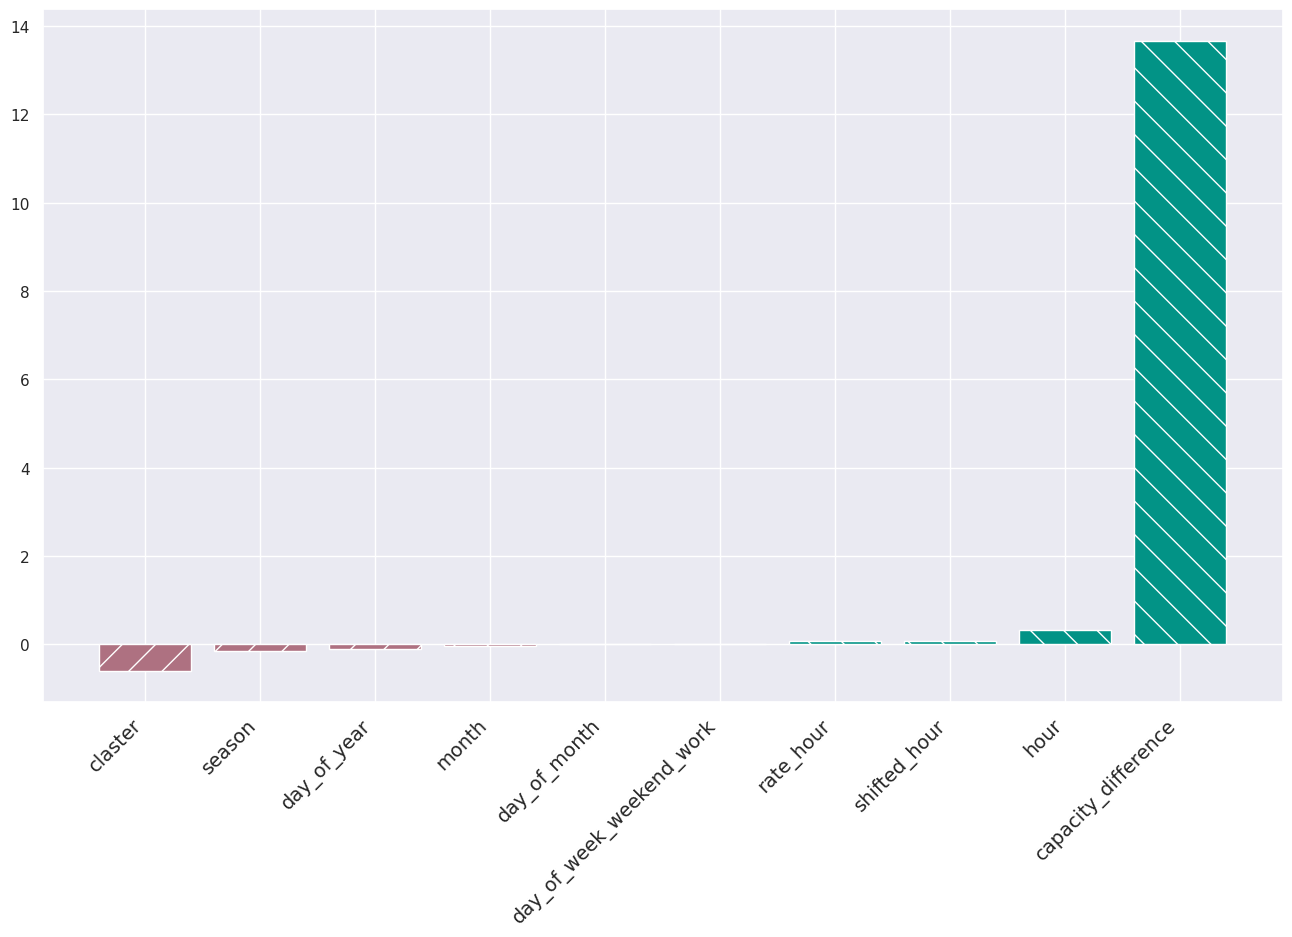

In [84]:
visualize_coefficients(model.coef_, feature_names, 15)

In [89]:
params_df = full_df.drop(['capacity', 'timestamp'], axis=1)

pathReal = Path.cwd() / 'smart_meters_london_2013.csv'
result_df = pd.read_csv(pathReal, index_col='timestamp')

ids = params_df['id']
max_id = ids[len(ids) - 1]

df_without_id = params_df.drop(['id'], axis=1)

for i in tqdm(range(0, max_id)):
    if i in ids:
        result_df[str(i)] = model.predict(scl.transform(df_without_id.loc[ids == i]))

100%|██████████| 1679/1679 [00:13<00:00, 123.27it/s]


In [90]:
result_df

,0,1,2,3,4,5,6,7,8,9,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.449190,2.237488,0.156709,0.252282,0.092834,0.390598,0.938374,-0.310588,-0.166989,0.545243,...,0.585,0.256,3.311,0.190,0.263,0.246,0.141,0.547,0.215,0.119
2013-01-01 01:00:00,0.229045,0.223077,0.321256,0.196867,0.245374,0.208874,0.916579,0.610855,0.289078,0.130111,...,0.493,0.192,1.695,0.222,0.231,0.221,0.131,0.474,0.227,0.103
2013-01-01 02:00:00,0.255276,0.644085,0.186598,0.244710,0.262480,0.232223,0.498085,0.306184,0.222618,0.176993,...,0.423,0.200,1.038,0.268,0.236,0.207,0.131,0.252,0.220,0.285
2013-01-01 03:00:00,0.271901,0.817276,0.361230,0.277664,0.279585,0.225315,0.897480,-0.209323,0.272861,0.234921,...,0.182,0.262,0.586,0.119,0.188,0.220,0.104,0.091,0.202,0.097
2013-01-01 04:00:00,0.134089,0.550754,0.136010,0.214293,0.217655,0.168188,0.755827,0.129767,0.264241,0.280570,...,0.262,0.205,0.555,0.149,0.165,0.238,0.119,0.086,0.208,0.103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.482322,1.089651,0.524105,0.077459,0.417966,0.397795,0.557038,0.619677,0.405479,0.451104,...,1.039,0.891,1.371,0.158,0.540,0.216,0.649,0.928,0.220,0.227
2013-12-31 20:00:00,0.783743,1.015987,0.378881,0.462447,0.455723,0.104650,1.062092,0.500868,0.445638,0.466769,...,0.712,0.740,1.324,0.072,0.378,0.267,0.263,0.774,0.221,0.112
2013-12-31 21:00:00,0.261032,1.062388,0.562638,0.440171,0.472829,0.648605,0.619585,0.281203,0.525658,0.422401,...,0.504,1.193,1.073,0.109,0.270,0.279,0.294,0.802,0.220,0.104


In [93]:
result_df.to_csv('alex_res.csv')

In [57]:
def plot_data_multiple(data, n_records=168, cols=None, n_data_cols=5, start = None):
  fig, ax = plt.subplots(figsize=(21, 4.5))
  if start == None:
    start = random.randrange(0, len(data.columns) - n_records)
  index = data[start:start + n_records].index
  ax.set_title(str(n_data_cols) + " sample records with duration of " + str(n_records) + " hours (" + str(n_records/(24*7)) + " weeks)")
  ax.set_xlabel("Time")
  ax.set_ylabel("Power consumption")
  if cols == None:
    for i in random.sample(list(data.columns), n_data_cols):
      ax.plot(index, data[str(i)][start:start + n_records], label="data" + str(i))
  else:
    for i in cols:
      ax.plot(index, data[str(i)][start:start + n_records], label="data" + str(i))
  ax.legend()
  plt.show()

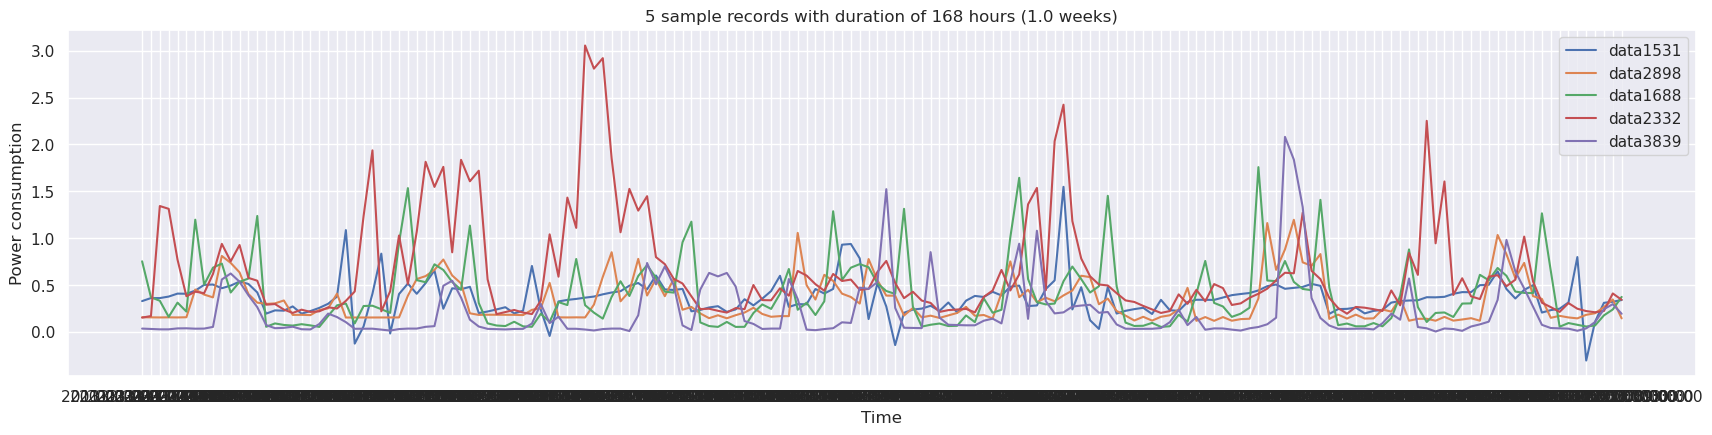

In [92]:
plot_data_multiple(result_df, 24 * 7)